# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [9]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your dataset and preprocess it if necessary
train = "/content/drive/MyDrive/exercise09_datacollection/stsa-test.txt"
test = "/content/drive/MyDrive/exercise09_datacollection/stsa-train.txt"

def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(" ", 1)
                label = int(parts[0])
                text = parts[1]
                data.append((text, label))
    return data

train_data = load_data(train)
test_data = load_data(test)

# Convert data to DataFrame
train_df = pd.DataFrame(train_data, columns=['review', 'sentiment'])
test_df = pd.DataFrame(test_data, columns=['review', 'sentiment'])

# Display a sample of the data
print("Training data sample:")
print(train_df.head())

print("\nTest data sample:")
print(test_df.head())

# Preprocessing function
def preproc(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Applying preprocessing
train_df['review'] = train_df['review'].apply(preproc)
test_df['review'] = test_df['review'].apply(preproc)

# Split train data into features and labels
X_train = train_df['review']
y_train = train_df['sentiment']

# Split test data into features and labels
X_test = test_df['review']
y_test = test_df['sentiment']

# Converting training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Word2Vec model
word2vec_model = Word2Vec(sentences=train_df['review'], vector_size=100, window=5, min_count=1, workers=4)

# Extract Word2Vec features
def word2vec_features(text):
    # Tokenize text
    tokens = text.split()
    # Compute average word vectors
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)  # Return zeros if no valid word vectors found
    else:
        return np.mean(word_vectors, axis=0)

X_train_word2vec = np.vstack([word2vec_features(text) for text in X_train])
X_val_word2vec = np.vstack([word2vec_features(text) for text in X_val])
X_test_word2vec = np.vstack([word2vec_features(text) for text in X_test])

# Define classifiers
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

# Define evaluation metrics
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1": f1_score,
}

# Results dictionary to store evaluation results
results = {}

# Evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Evaluating {clf_name}...")
    # Train classifier using cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train_tfidf, y_train, cv=kf, scoring='accuracy')
    # Fit classifier on entire training data
    clf.fit(X_train_tfidf, y_train)
    # Predict on validation data
    y_pred = clf.predict(X_val_tfidf)
    # Compute evaluation scores
    eval_scores = {metric_name: metric(y_val, y_pred) for metric_name, metric in metrics.items()}
    # Store results
    results[clf_name] = {
        "CrossValidationScores": scores,
        "ValidationScores": eval_scores,
    }

# Print test scores for each classifier
for clf_name, scores in results.items():
    print(f"Test scores for {clf_name}:")
    for metric_name, score in scores.items():
        print(f"{metric_name}: {score}")
    print()

# Choose the best performing classifier based on validation scores
best_clf_name = max(results, key=lambda x: results[x]["ValidationScores"]["Accuracy"])
best_clf = classifiers[best_clf_name]
print(f"Best performing classifier: {best_clf_name}")

# Train the final model on the entire training data using TF-IDF features
best_clf.fit(X_train_tfidf, y_train)

# Evaluate the final model on the test data using TF-IDF features
y_pred_test = best_clf.predict(X_test_tfidf)
test_scores = {metric_name: metric(y_test, y_pred_test) for metric_name, metric in metrics.items()}
print("Test Scores using TF-IDF features:")
print(test_scores)

#BERT
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel

# Training the BERT model
model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels=2,
    args={"reprocess_input_data": True, "overwrite_output_dir": True, "num_train_epochs": 1},
    use_cuda=False
)


# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df)

# Print evaluation result
print(result)


Training data sample:
                                              review  sentiment
0     no movement , no yuks , not much of anything .          0
1  a gob of drivel so sickly sweet , even the eag...          0
2  gangs of new york is an unapologetic mess , wh...          0
3  we never really feel involved with the story ,...          0
4            this is one of polanski 's best films .          1

Test data sample:
                                              review  sentiment
0  a stirring , funny and finally transporting re...          1
1  apparently reassembled from the cutting-room f...          0
2  they presume their audience wo n't sit still f...          0
3  this is a visually stunning rumination on love...          1
4  jonathan parker 's bartleby should have been t...          1


Evaluating MultinomialNB...
Evaluating SVM...
Evaluating KNN...
Evaluating DecisionTree...
Evaluating RandomForest...
Evaluating XGBoost...
Test scores for MultinomialNB:
CrossValidationScores: [0.75342466 0.74657534 0.67808219 0.73972603 0.75342466 0.76712329
 0.7862069  0.77241379 0.68965517 0.73103448]
ValidationScores: {'Accuracy': 0.7178082191780822, 'Precision': 0.7543859649122807, 'Recall': 0.6789473684210526, 'F1': 0.7146814404432134}

Test scores for SVM:
CrossValidationScores: [0.74657534 0.69863014 0.66438356 0.70547945 0.71232877 0.71232877
 0.75172414 0.73103448 0.73793103 0.71724138]
ValidationScores: {'Accuracy': 0.6931506849315069, 'Precision': 0.7191011235955056, 'Recall': 0.6736842105263158, 'F1': 0.6956521739130435}

Test scores for KNN:
CrossValidationScores: [0.71232877 0.64383562 0.64383562 0.67808219 0.65068493 0.69178082
 0.71034483 0.67586207 0.60689655 0.68965517]
ValidationScores: {'Accuracy': 0.6328767123287671, 'Precision': 0.6555555555555556, 'Recall': 0.6

'!pip install simpletransformers\nfrom simpletransformers.classification import ClassificationModel\n\n# Training the BERT model\nmodel = ClassificationModel(\n    "bert",\n    "bert-base-uncased",\n    num_labels=2,\n    args={"reprocess_input_data": True, "overwrite_output_dir": True, "num_train_epochs": 1},\n    use_cuda=False\n)\n\n\n# Train the model\nmodel.train_model(train_df)\n\n# Evaluate the model\nresult, model_outputs, wrong_predictions = model.eval_model(test_df)\n\n# Print evaluation result\nprint(result)'

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


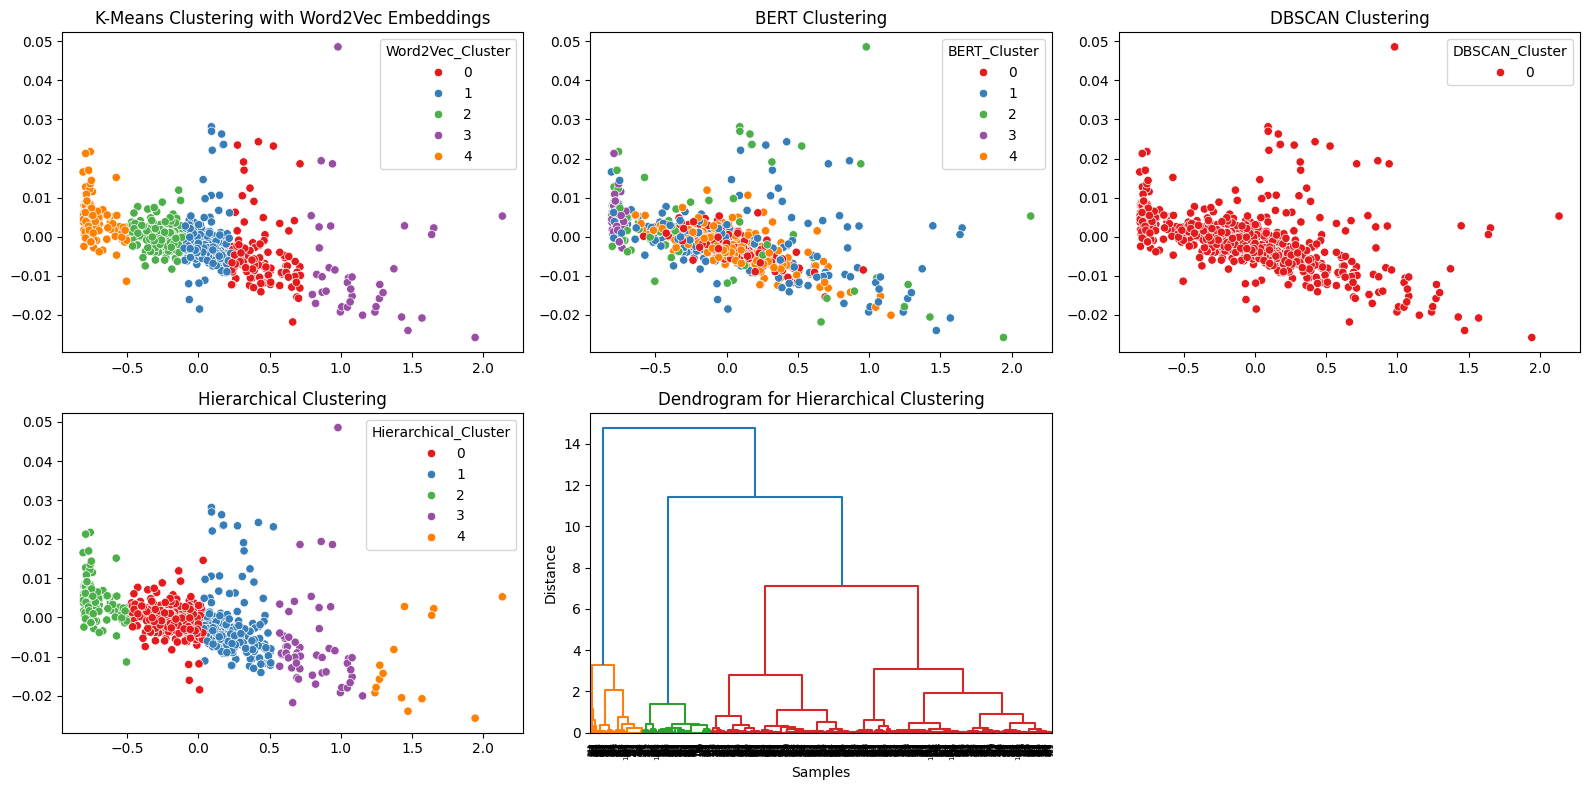

                                             Reviews  Word2Vec_Cluster  \
0  feel lucky found used (phone u & used hard all...                 2   
1  nice phone, nice grade pantach revue. clean se...                 1   
2                                            pleased                 4   
3        work good go slow sometimes good phone love                 3   
4  great phone replace lost phone. thing volume b...                 1   

   BERT_Cluster  DBSCAN_Cluster  Hierarchical_Cluster  
0             0               0                     0  
1             0               0                     1  
2             2               0                     2  
3             1               0                     3  
4             0               0                     1  


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import nltk
from nltk.corpus import stopwords
from textblob import Word

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load stopwords for English
stop = stopwords.words('english')

df = pd.read_csv("/content/drive/MyDrive/Amazon_Unlocked_Mobile.csv")

# Convert to lowercase
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# Remove punctuation
df['Reviews'] = df['Reviews'].str.replace('[^\w\s]','')
# Remove stopwords
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Lemmatization
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Display the DataFrame
df.head()


# Word2Vec
word2vec_model = Word2Vec(sentences=[review.split() for review in df['Reviews']], vector_size=100, window=5, min_count=1, workers=4)
word2vec_embeddings = [np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv], axis=0) for review in df['Reviews']]

# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
bert_embeddings = []
for review in df['Reviews']:
    inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    bert_embeddings.append(torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy())

# Perform K-means clustering using Word2Vec embeddings
kmeans_word2vec = KMeans(n_clusters=5, random_state=42)
kmeans_word2vec.fit(word2vec_embeddings)
df['Word2Vec_Cluster'] = kmeans_word2vec.labels_

# Perform K-means clustering using BERT embeddings
kmeans_bert = KMeans(n_clusters=5, random_state=42)
kmeans_bert.fit(bert_embeddings)
df['BERT_Cluster'] = kmeans_bert.labels_

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(word2vec_embeddings)
df['DBSCAN_Cluster'] = dbscan.labels_

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical.fit(word2vec_embeddings)
df['Hierarchical_Cluster'] = hierarchical.labels_

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(word2vec_embeddings)

# Visualize results
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Word2Vec_Cluster'], palette='Set1', legend='full')
plt.title('K-Means Clustering with Word2Vec Embeddings')

plt.subplot(2, 3, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['BERT_Cluster'], palette='Set1', legend='full')
plt.title('BERT Clustering')

plt.subplot(2, 3, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['DBSCAN_Cluster'], palette='Set1', legend='full')
plt.title('DBSCAN Clustering')

plt.subplot(2, 3, 4)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Hierarchical_Cluster'], palette='Set1', legend='full')
plt.title('Hierarchical Clustering')

# Plot dendrogram for hierarchical clustering
plt.subplot(2, 3, 5)
dendrogram_ = dendrogram(linkage(word2vec_embeddings, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()

# Display the DataFrame with clusters
print(df[['Reviews', 'Word2Vec_Cluster', 'BERT_Cluster', 'DBSCAN_Cluster', 'Hierarchical_Cluster']].head())

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.
K-means, DBSCAN, and Hierarchical clustering collected data points according to their similarity, with K-means generating spherical clusters, DBSCAN finding clusters of any forms, and Hierarchical clustering constructing a tree-like structure. In contrast, Word2Vec and BERT encode semantic similarities in text data.
.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [11]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

The overall assignment is good. I have learned implementing all the models.



'''

'\nPlease write you answer here:\n\nThe overall assignment is good. I have learned implementing all the models. \n\n\n\n'